# Overview
Use this notebook to convert an OCT image you have to an H&E image in order to evaluate how the code works.

To get started,
[Open this notebook in colab](https://) and run.

## Notebook's Inputs:

In [1]:
# Path to an OCT image to convert
oct_input_image_path = "/content/drive/Shareddrives/Yolab - Current Projects/Paulo de Luna/Pix2Pix/test_results/oct2_he_pix2pix/test_latest/images/LG-44-Slide04_Section02_yp0_patch01_real_real_A.png"

# Path to a folder in drive to output the converted H&E images, leave blank if
# you don't want to save H&E image to drive.
histology_output_image_folder = ""

# Set Up Environment
Clone repository and install dependencies:

In [2]:
import os

# Clone repository
!git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-UseModel

base_folder = "/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix"

# Install dependencies
!pip install -r {base_folder}/requirements.txt

# Clean up this window once install is complete
from IPython.display import clear_output
#clear_output()

Cloning into 'OCT2Hist-UseModel'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 36 (delta 8), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (36/36), 8.17 KiB | 1.17 MiB/s, done.
Submodule 'pytorch-CycleGAN-and-pix2pix' (https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) registered for path 'pytorch-CycleGAN-and-pix2pix'
Cloning into '/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2513, done.        
remote: Total 2513 (delta 0), reused 0 (delta 0), pack-reused 2513        
Receiving objects: 100% (2513/2513), 8.20 MiB | 26.14 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
Submodule path 'pytorch-CycleGAN-and-pix2pix': checked out '9f8f61e5a375c2e01c5187d093ce9c2409f409b0'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━

Copy model weights from google drive

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')

# This is the folder that the pre-trained model is in
model_folder = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x Model (Paper V2)"

# Copy model to this folder over
!mkdir {base_folder}/checkpoints
!mkdir {base_folder}/checkpoints/pix2pix/
!cp "{model_folder}/latest_net_G.pth" {base_folder}/checkpoints/pix2pix/
!cp "{model_folder}/latest_net_D.pth" {base_folder}/checkpoints/pix2pix/

Mounted at /content/drive/


# Preprocess
Mask images, crop and convert to the right size

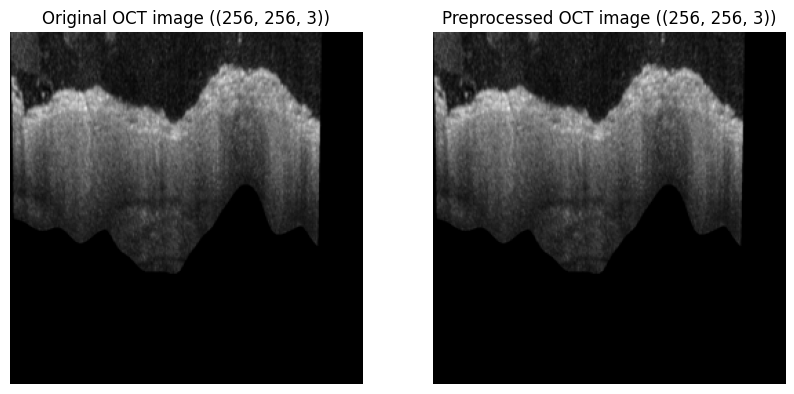

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load OCT image
oct_image_orig = cv2.imread(oct_input_image_path)
oct_image_orig = cv2.cvtColor(oct_image_orig, cv2.COLOR_BGR2RGB)

# Show Images to user
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
oct_image_orig_shape = oct_image_orig.shape
axes[0].imshow(oct_image_orig)
axes[0].axis("off")
axes[0].set_title(f"Original OCT image ({oct_image_orig_shape})")

# Perform pre-process
# Todo - DANNY to add pre process here, for now we just resize
oct_image_preprocessed = oct_image_orig

# Show image to user
oct_image_preprocessed_shape = oct_image_preprocessed.shape
axes[1].imshow(oct_image_orig)
axes[1].axis("off")
axes[1].set_title(f"Preprocessed OCT image ({oct_image_preprocessed_shape})")
plt.show()

Format image the way that pix2pix code likes it

In [5]:
# Create a folder and place OCT image
!mkdir {base_folder}/dataset
!mkdir {base_folder}/dataset/test/

# Before writting image to file, check size
if oct_image_preprocessed.shape[:2] != (256, 256):
        raise ValueError("Image size must be 256x256 pixels to run model on.")

# Padd image and write it to the correct place
padded = np.zeros([256,512,3], np.uint8)
padded[:,:256,:] = oct_image_preprocessed[:,:,:]
cv2.imwrite(f"{base_folder}/dataset/test/im1.jpg", padded)

True

# Run Model

In [6]:
!python {base_folder}/test.py --netG resnet_9blocks --dataroot "{base_folder}/dataset/"  --model pix2pix --name pix2pix --checkpoints_dir "{base_folder}/checkpoints" --results_dir "{base_folder}/results"

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: /content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix/checkpoints	[default: ./checkpoints]
                crop_size: 256                           
                 dataroot: /content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix/dataset/	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False  

# Show results

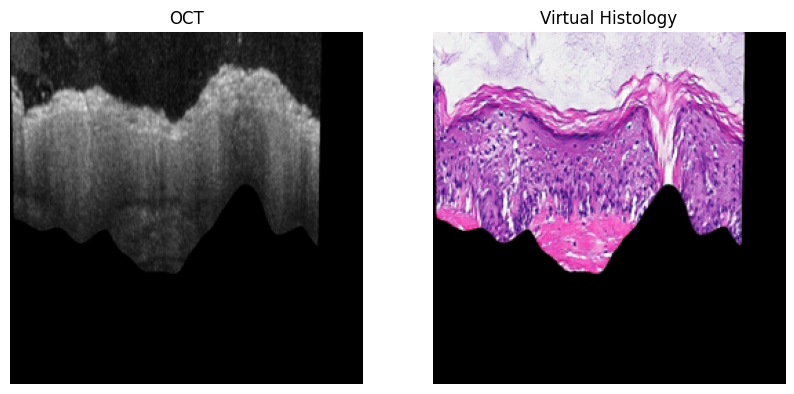

In [7]:
# Load the virtual histology image
histology_image = cv2.imread(f"{base_folder}/results/pix2pix/test_latest/images/im1_fake_B.png")
histology_image = cv2.cvtColor(histology_image, cv2.COLOR_BGR2RGB)

# present side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(oct_image_orig)
axes[0].axis("off")
axes[0].set_title("OCT")
axes[1].imshow(histology_image)
axes[1].axis("off")
axes[1].set_title("Virtual Histology")
plt.show()
